# Dimensionality Expansion in an MNIST Autoencoder with 3 Hidden Layers

This notebook is the same as the notebook 'autoencoder_full', except that we construct the network with the goal to be able to keep all the information, i.e., we don't want to learn a lossy compression.

For more information about the network and training process, pls refer to the original notebook.

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import math

import numpy as np

from IPython.display import HTML

%matplotlib inline

# Download and read mnist data
mnist = input_data.read_data_sets('mnist_data', one_hot=True)

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


### Hidden Layer sizes

How do we determine the size of a hidden layer $h$? Given that the input layer has $m$ neurons. Then we assume (considering an activation function for neurons that is arbitrarily close to a Heaviside function), that the input layer has $2^m$ different activation vectors. We want to enforce a sparsity in $h$, such that each of its activation vectors has only $k$ elements activated. If $h$ has $n$ neurons, then the number of different activation vectors is ${n \choose k}$.

It holds that

\begin{equation}
        {n \choose k} \geq \big( \frac{n}{k} \big)^k
\end{equation}

We use this inequality, to determine an $n$ that is definately sufficient to represent the input with respect to k (and the binary activation assumption).

\begin{align}
        & 2^m = \big( \frac{n}{k} \big)^k \\
       \leftrightarrow & n = \big\lceil k \cdot 2^{\frac{m}{k}} \big\rceil
\end{align}

As an alternative, one could consider the relation

\begin{equation}
        {n \choose k} \leq \frac{n^k}{k!}
\end{equation}

which is often a better approximation of the binomial coefficient.

\begin{equation}
        \rightarrow n = \bigg\lceil \prod_{i=1}^k i^{\frac{1}{k}} \cdot 2^{\frac{m}{k}} \bigg\rceil
\end{equation}

(Note, that the computation of $k!^{\frac{1}{k}}$ might not be feasible.)

However, this second way might not lead to an sufficiently high $n$ to represent all information, if $k$ is a hard constraint.

#### A more relaxed sparsity constraint

What if $k$ is only an upper bound of active neurons, but any number $o \leq k$ is equally valid? Then, the hidden layer would have $\sum_{i=0}^k {n \choose i}$ possible activations.

As this coding scheme would be much more efficient, it should be preferred. However, therefore we need a sparsity constraint, that only punishes activation levels above $k$, e.g., $ReLU(-k + \sum_i h_i)$.

#### What about MNIST?

MNIST samples are already extremely sparse, as all pixel values are clustered around the center (corner pixels are always black). The average number of non-zero pixels is a much better estimate of the input size $m$.

In [2]:
# Exponential smoothing factor.
gamma = 0.99

# Note, sparsity is defined relative to the input size.
# sparsity: [first/third hidden layer, second hidden layer]
rel_sparsity = [0.5, 0.8]

# Influence of sparsity constraint to loss
alph_s = 5.
# Influence of participation constraint to loss
alph_p = 1000.
# Influence of the binary output constraint to the loss
alph_b = 1.

size_input = 784

# Initial learning rate
lr = 50

batch_size = 32

def layer_size(m, k):
    """Determine the "optimal" size of the hidden layer, given the input layer size
    and the sparsity, such that no information has to get lost. We assume a binary
    layer representation, such that 2**m <= nCk.
    
    Args:
        m: Number of neurons in input layer.
        k: Number of neurons, that should be co-active in the layer.
        
    Returns:
        n: Number of neurons, that should be in the hidden layer."""
    
    return int(np.ceil(k * 2**(float(m)/k)))

#input_m = size_input
input_m = np.round(np.mean(np.count_nonzero(mnist.train.images, axis=1)))

h1_k = np.round((1-rel_sparsity[0]) * input_m)
h2_k = np.round((1-rel_sparsity[1]) * input_m)

size_h1 = layer_size(input_m, h1_k)
size_h2 = layer_size(input_m, h2_k)

# Redefine sparsity layer-wise.
sparsity = [float(1.-h1_k/size_h1), float(1.-h2_k/size_h2)]
sparsity.append(sparsity[0])

#size_h1 = 800
#size_h2 = 1000
#sparsity = [0.5,0.8,0.5]

print('Number of neurons in first/third hidden layer: %d (sparsity: %.2f)' % (size_h1, sparsity[0]))
print('Number of neurons in second hidden layer: %d (sparsity: %.2f)' % (size_h2, sparsity[1]))

Number of neurons in first/third hidden layer: 300 (sparsity: 0.75)
Number of neurons in second hidden layer: 960 (sparsity: 0.97)


Starting training ...
step 0, training loss 5.76009


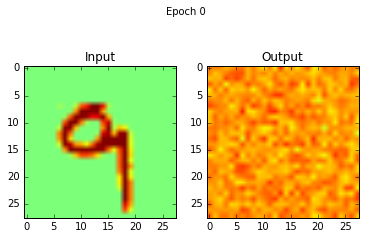

step 1000, training loss 0.861079


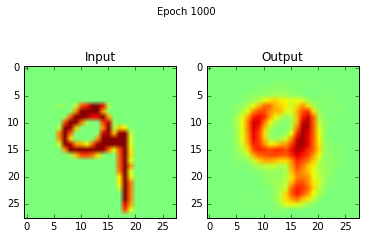

step 2000, training loss 0.573604


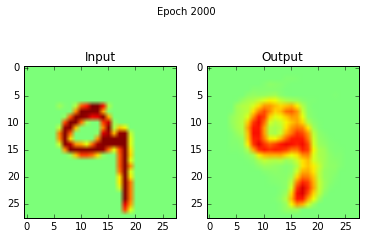

step 3000, training loss 0.470818


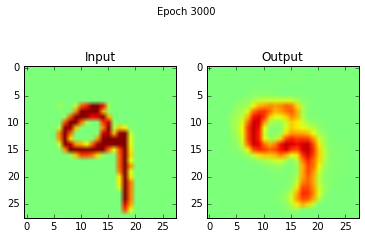

step 4000, training loss 0.476991


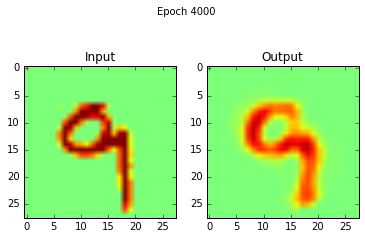

step 5000, training loss 0.443606


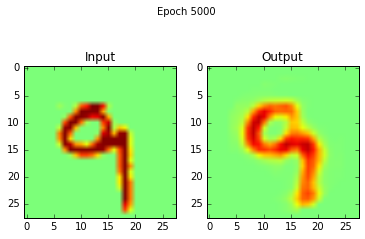

step 6000, training loss 0.437819


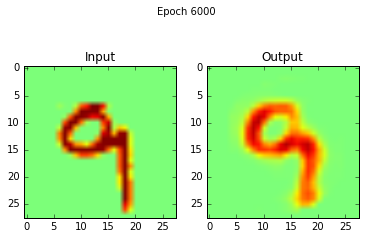

step 7000, training loss 0.45477


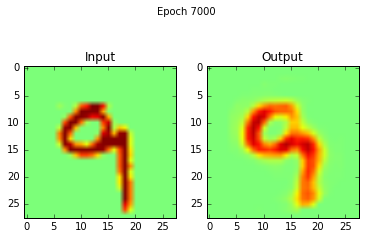

step 8000, training loss 0.403666


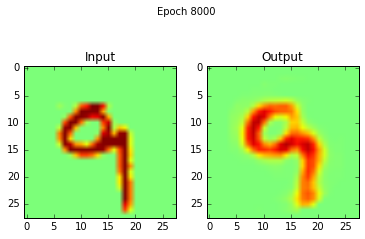

step 9000, training loss 0.41978


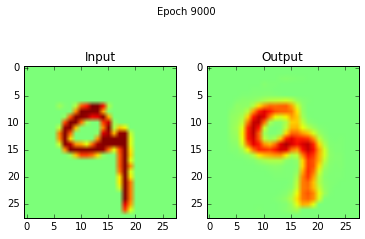

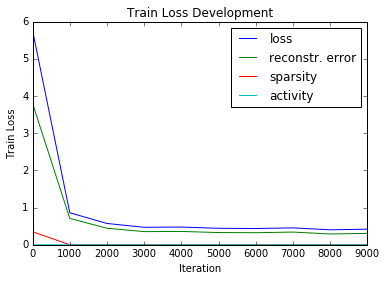

In [3]:
tf.reset_default_graph()

def sshift(c, k=100.):
    """How to shift the sigmoid along the x-axis, such that sigmoid(0) = c.

    Args:
        c: y-value of sigmoid(0).
        k: Stretching factor of sigmoid.

    Returns:
        Returns x_s such that sigmoid(x-x_s) = c for x = 0. Note, that the original sigmoid has the property that
        sigmoid(x) = 0.5 for x = 0.
    """
    return 1./k * tf.log((1.-c)/c)

def sigmoid(x, x_s, k=100.):
    """Compute a sigmoid fuction.

    Args:
        x: Input to sigmoid
        c: y-value of sigmoid(0).
        k: Stretching factor of sigmoid.

    Returns:
        Returns 1/(1+exp(-k*(x-x_s)))
    """
    return tf.div(1.,tf.add(1.,tf.exp(-k * (x-x_s))))

# Create a five layer fully-connected network:
# size_input -> size_h1 -> size_h2 -> size_h1 -> size_input
inputs = tf.placeholder(tf.float32, shape=[None, size_input])
learning_rate = tf.placeholder(tf.float32, shape=[])

activity_trace_h1 = tf.placeholder(tf.float32, shape=[size_h1])
activity_trace_h2 = tf.placeholder(tf.float32, shape=[size_h2])
activity_trace_h3 = tf.placeholder(tf.float32, shape=[size_h1])

h1 = tf.contrib.layers.fully_connected(inputs, size_h1, activation_fn=tf.nn.sigmoid)

h2 = tf.contrib.layers.fully_connected(h1, size_h2, activation_fn=tf.nn.sigmoid)

h3 = tf.contrib.layers.fully_connected(h2, size_h1, activation_fn=tf.nn.sigmoid)

outputs = tf.contrib.layers.fully_connected(h3, size_input, activation_fn=tf.nn.sigmoid)

# Reconstruction Error
# As the other loss terms (e.g. sparsity) are normalized to layer sizes, we should do this here too
# Note, that the function L2 loss doesn't use the sqrt op.
rec_err = tf.nn.l2_loss(outputs-inputs) / float(size_input)

# Compute sparsity within layer
# (We only consider hidden layers, as the other layer shall be fully governed by the input)
loss_s = 0
# Compute binary loss.
loss_b = 0
for ii, layer in enumerate([h1,h2,h3]):
    n_l = float(int(layer.shape[1]))
    participation = (1.-sparsity[ii])
    loss_s += tf.reduce_mean(tf.reduce_sum(layer, 1)/n_l - participation)**2
    
    loss_b += tf.reduce_mean(tf.pow(layer,2)*tf.pow(layer-1,2))
    
# Add participation loss for all neurons
loss_p = 0
activity_traces = [activity_trace_h1, activity_trace_h2, activity_trace_h3]
for ii, layer in enumerate([h1,h2,h3]):
    n_l = float(int(layer.shape[1]))
    a_trace = activity_traces[ii]
    
    participation = (1.-sparsity[ii])
    x_s = sshift(participation) # sigmoid shift
    
    ## Simple loss (unstable minima)
    #loss_p += tf.reduce_mean(tf.reduce_sum((gamma*a_trace + (1-gamma)*layer - participation)**2, 1)/n_l)
    
    ## Loss with minimas relatively stable around 0 or 1 (depending on trace error)
    # Root of the simple loss formulation.
    root = - 1/(1-gamma) * (gamma*a_trace - participation)
    sigval = sigmoid(participation - a_trace, x_s)
    loss_p += tf.reduce_mean(tf.reduce_sum( \
        (gamma*a_trace + (1-gamma)*layer - participation + (1-gamma) * (root - sigval))**2, 1)/n_l)
    
loss = rec_err + alph_s * loss_s + alph_p * loss_p + alph_b * loss_b

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

tf.set_random_seed(42)

train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

print('Starting training ...')

# Choose a test sample, which will show the training progress during eval iterations.
test_batch = mnist.test.next_batch(1)

loss_values = []

# Monitor the hidden activations, to visualize the sparsity.
hidden_activations = []

# Monitor the activation traces to visualize their evolution.
activation_traces_train = []

# Initial activation traces.
#at_h1 = np.expand_dims(np.ones(size_h1) * sparsity, axis=0)
at_h1 = np.ones(size_h1) * (1.-sparsity[0])
at_h2 = np.ones(size_h2) * (1.-sparsity[1])
at_h3 = np.ones(size_h1) * (1.-sparsity[2])

for i in range(10000):
    batch = mnist.train.next_batch(batch_size)
    
    # Eval current training stage
    if i % 1000 == 0:
        lr /= 2
        train_loss, train_err, train_sp, train_a = sess.run([loss, rec_err, loss_s, loss_p], feed_dict={
            inputs: batch[0], learning_rate: lr, \
            activity_trace_h1: at_h1, activity_trace_h2: at_h2, activity_trace_h3: at_h3})
        
        loss_values.append((i, train_loss, train_err, train_sp, train_a))
        print("step %d, training loss %g" \
              % (i, train_loss))
        
        # Evaluation on test sample
        h1_activity, h2_activity, h3_activity = sess.run([h1,h2,h3], feed_dict={
            inputs: test_batch[0], learning_rate: lr, \
            activity_trace_h1: at_h1, activity_trace_h2: at_h2, activity_trace_h3: at_h3})
        
        hidden_activations.append((i, h1_activity, h2_activity, h3_activity))
        
        activation_traces_train.append((i, at_h1, at_h2, at_h3))

        outs = outputs.eval(feed_dict={
                    inputs: test_batch[0], learning_rate: lr, \
            activity_trace_h1: at_h1, activity_trace_h2: at_h2, activity_trace_h3: at_h3})
        fig = plt.figure()
        plt.suptitle('Epoch %d' % (i))
        ax = fig.add_subplot(1,2,1)
        ax.imshow(test_batch[0].reshape((28,28)), vmin=-1.0, vmax=1.0)
        ax.set_title('Input')
        ax = fig.add_subplot(1,2,2)
        ax.imshow(outs.reshape((28,28)), vmin=-1.0, vmax=1.0)
        ax.set_title('Output')
        plt.show()
        
    # Run backprop
    train_step.run(feed_dict={inputs: batch[0], learning_rate: lr, \
            activity_trace_h1: at_h1, activity_trace_h2: at_h2, activity_trace_h3: at_h3})
    
    # Update activity traces
    activity_h1, activity_h2, activity_h3 = sess.run([h1, h2, h3], feed_dict={inputs: batch[0], learning_rate: lr, \
        activity_trace_h1: at_h1, activity_trace_h2: at_h2, activity_trace_h3: at_h3})
    # We update the traces by the mean activity achieved in the current batch
    activity_h1 = np.mean(activity_h1, axis=0)
    activity_h2 = np.mean(activity_h2, axis=0)
    activity_h3 = np.mean(activity_h3, axis=0)
    
    at_h1 = gamma * at_h1 + (1-gamma) * activity_h1
    at_h2 = gamma * at_h2 + (1-gamma) * activity_h2
    at_h3 = gamma * at_h3 + (1-gamma) * activity_h3
    
xval, lval, erval, sval, aval = zip(*loss_values)
plt.plot(xval, lval, label="loss")
plt.plot(xval, erval, label="reconstr. error")
plt.plot(xval, sval, label="sparsity")
plt.plot(xval, aval, label="activity")
plt.legend()
plt.title("Train Loss Development")
plt.xlabel("Iteration")
plt.ylabel("Train Loss")
plt.show()

# Evolution of activity histograms to visualize sparsity

Here we plot histograms of the hidden layer activation over time. I.e., at each evaluation epoch, we take the activation of all hidden layers and plot a histogram of the contained values (bins of size 0.1). Ideally, (1-sparsity)% of the activations have the value one and sparsity% of the values have the value zero. However, it is hard to define a regularizer for sigmoid units, that enforces this behavior.

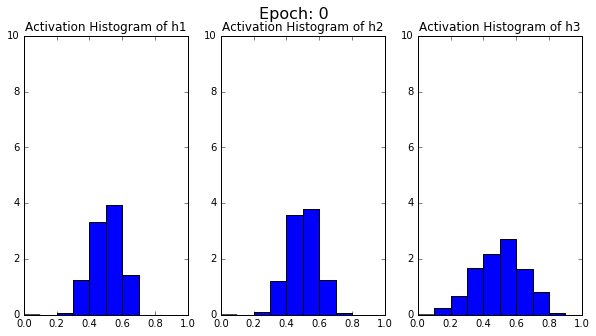

In [4]:
xval, h1val, h2val, h3val = zip(*hidden_activations)

number_of_frames = len(xval)

def update_hist(num):
    plt.cla()
    ax1.cla()
    ax2.cla()
    ax3.cla()
    
    ax1.set_ylim(0.0, 10.0)
    ax2.set_ylim(0.0, 10.0)
    ax3.set_ylim(0.0, 10.0)
    
    fig.suptitle('Epoch: %d' % xval[num], fontsize=16)
    
    ax1.hist(np.squeeze(h1val[num]), bins=np.linspace(0,1,11), range=(0.,1.), normed=True) 
    ax1.set_title('Activation Histogram of h1')

    ax2.hist(np.squeeze(h2val[num]), bins=np.linspace(0,1,11), range=(0.,1.), normed=True) 
    ax2.set_title('Activation Histogram of h2')

    ax3.hist(np.squeeze(h3val[num]), bins=np.linspace(0,1,11), range=(0.,1.), normed=True) 
    ax3.set_title('Activation Histogram of h3')

fig = plt.figure(figsize = (10,5))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

update_hist(0)

anim = animation.FuncAnimation(fig, update_hist, number_of_frames, interval=1000 )
#plt.show()
HTML(anim.to_html5_video())

# Evolution of activity trace histograms to visualize participation

Here we plot histograms of the hidden layer activity traces over time. I.e., at each evaluation epoch, we take a snapshot of the current activity trace for all hidden neurons. **Note**, unlike the hidden activations, the activity traces here are not monitored over a single test sample (as we would need to simulate the test sample every iteration). Instead, the activity trace is the same as used for training, thus it is computed from mean activations of training batches.

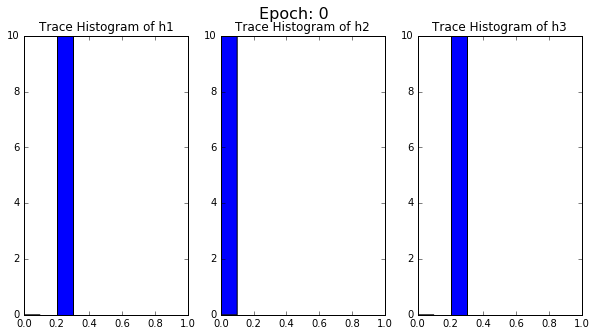

In [5]:
xval, h1val, h2val, h3val = zip(*activation_traces_train)

number_of_frames = len(xval)

def update_hist(num):
    plt.cla()
    ax1.cla()
    ax2.cla()
    ax3.cla()
    
    ax1.set_ylim(0.0, 10.0)
    ax2.set_ylim(0.0, 10.0)
    ax3.set_ylim(0.0, 10.0)
    
    fig.suptitle('Epoch: %d' % xval[num], fontsize=16)
    
    ax1.hist(np.squeeze(h1val[num]), bins=np.linspace(0,1,11), range=(0.,1.), normed=True) 
    ax1.set_title('Trace Histogram of h1')

    ax2.hist(np.squeeze(h2val[num]), bins=np.linspace(0,1,11), range=(0.,1.), normed=True) 
    ax2.set_title('Trace Histogram of h2')

    ax3.hist(np.squeeze(h3val[num]), bins=np.linspace(0,1,11), range=(0.,1.), normed=True) 
    ax3.set_title('Trace Histogram of h3')

fig = plt.figure(figsize = (10,5))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

update_hist(0)

anim = animation.FuncAnimation(fig, update_hist, number_of_frames, interval=1000 )
#plt.show()
HTML(anim.to_html5_video())

# Test samples

Random test samples from the test set to get an subjective impression of the autoencoder quality.

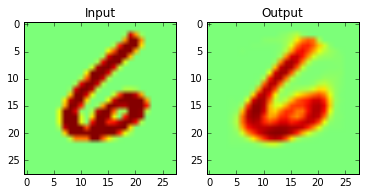

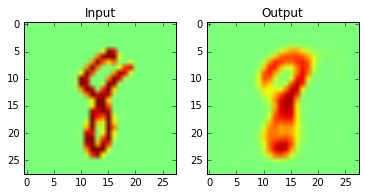

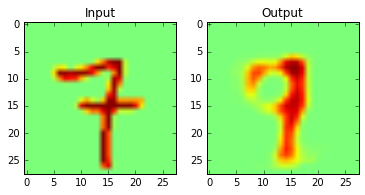

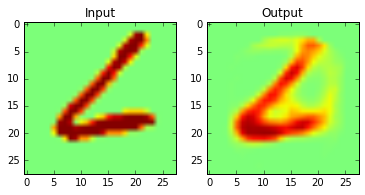

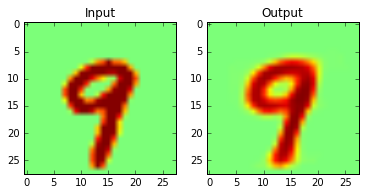

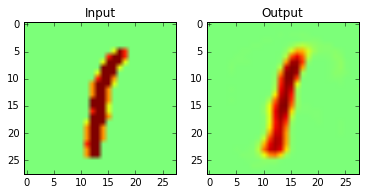

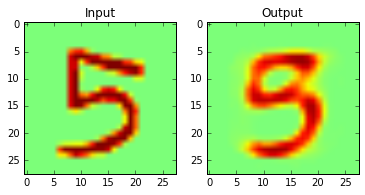

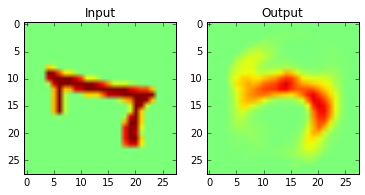

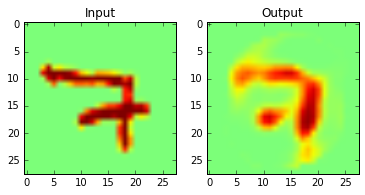

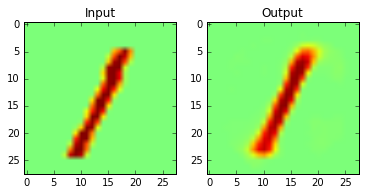

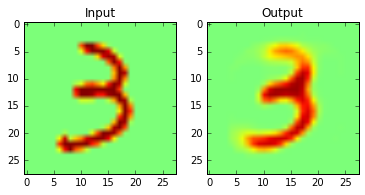

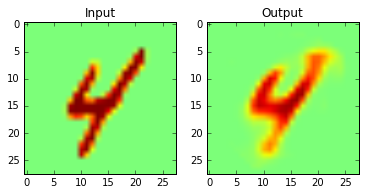

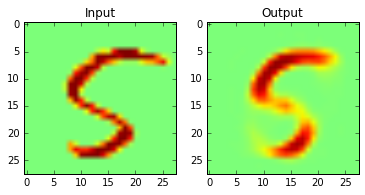

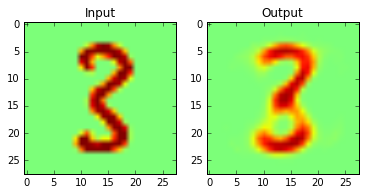

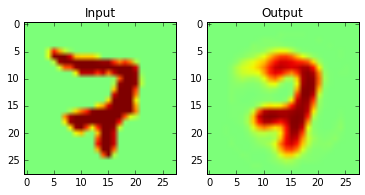

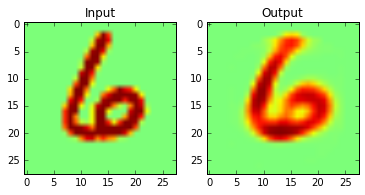

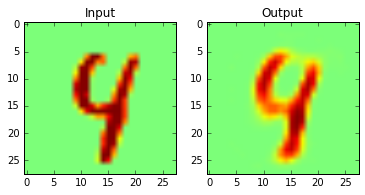

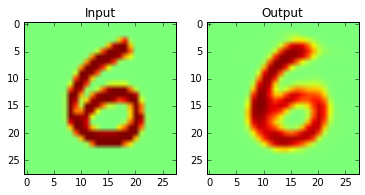

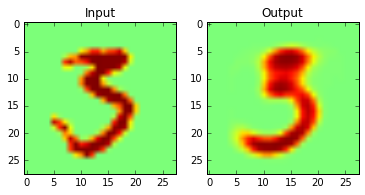

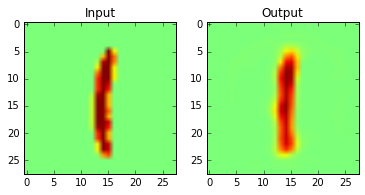

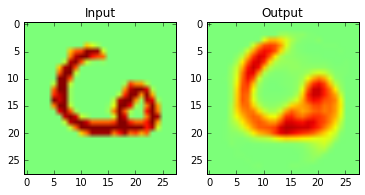

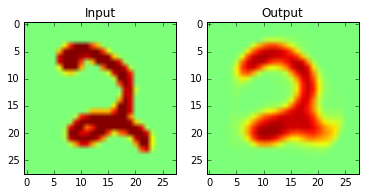

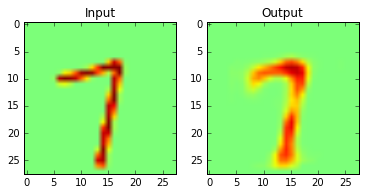

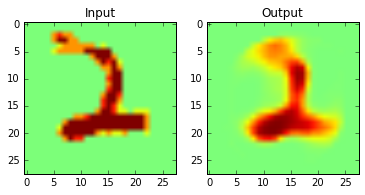

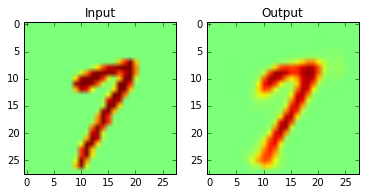

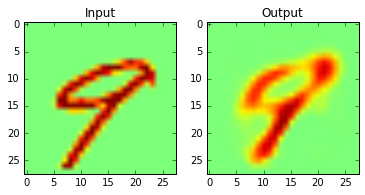

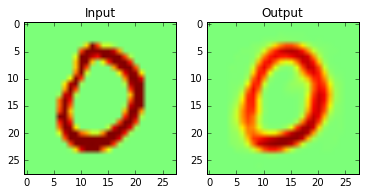

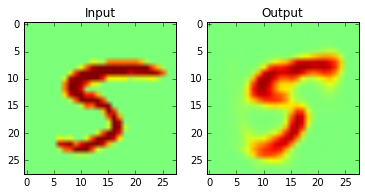

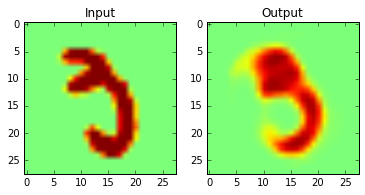

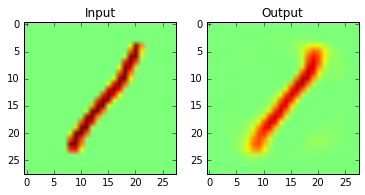

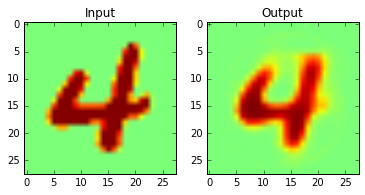

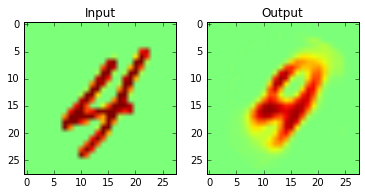

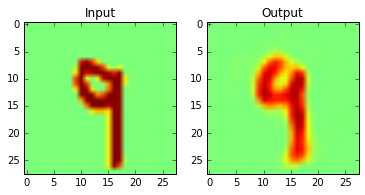

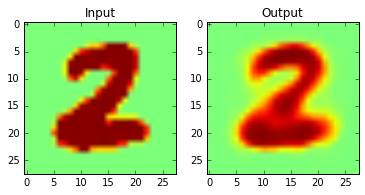

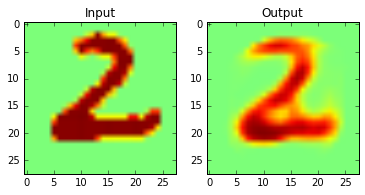

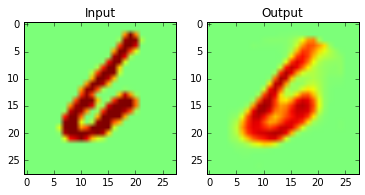

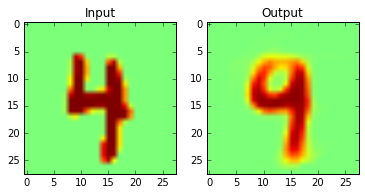

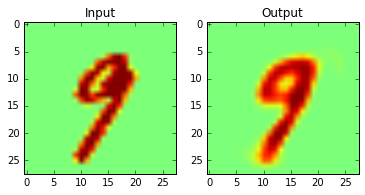

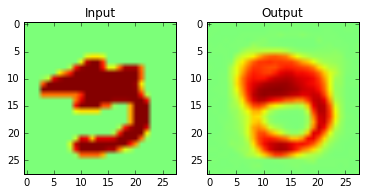

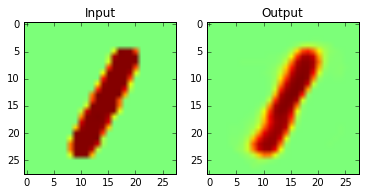

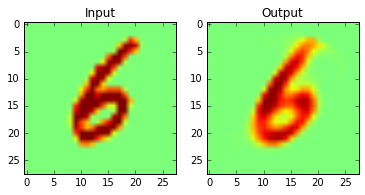

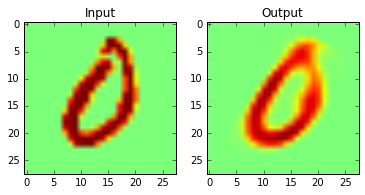

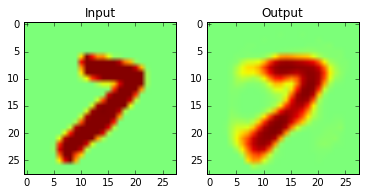

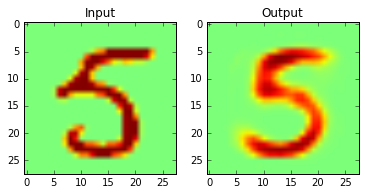

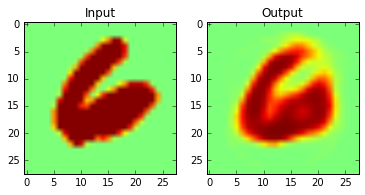

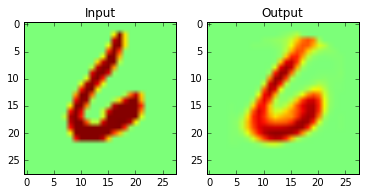

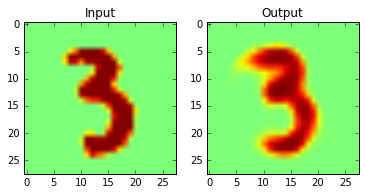

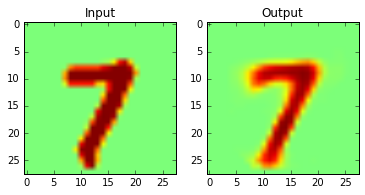

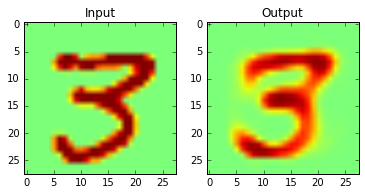

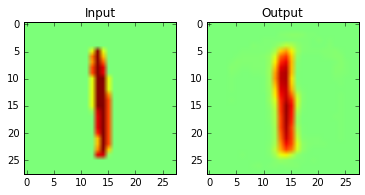

In [6]:
test_batch = mnist.test.next_batch(50)

outs = outputs.eval(feed_dict={
                    inputs: test_batch[0], learning_rate: lr})

for i in range(test_batch[0].shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(1,2,1)
    ax.imshow(test_batch[0][i,:].reshape((28,28)), vmin=-1.0, vmax=1.0)
    ax.set_title('Input')
    ax = fig.add_subplot(1,2,2)
    ax.imshow(outs[i,:].reshape((28,28)), vmin=-1.0, vmax=1.0)
    ax.set_title('Output')
    plt.show()

The evolution of the different loss components compared to the overall loss. Note, that is the same figure as above, just plotted with a better resolution. "loss" is the actual loss term that is optimized on consists of the other three components. "sparsity" measures how well the sparsity constraint within a layer is satisfied. "activity" evaluates the participation of all neurons (all neurons are involved in the network computation).

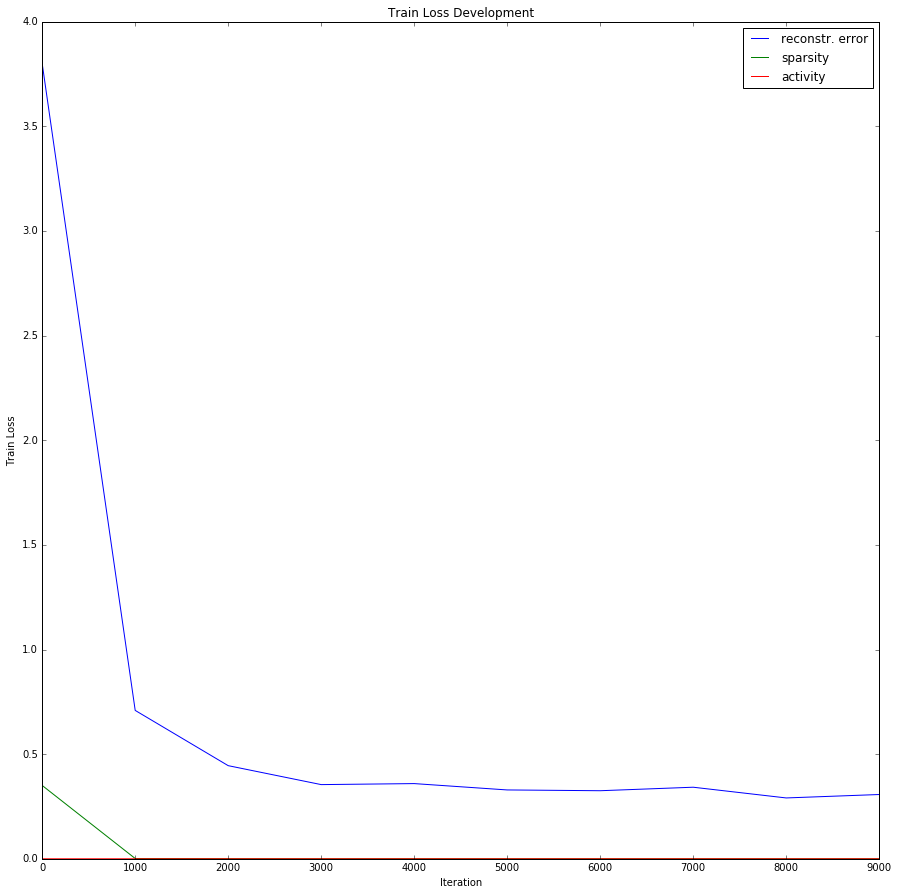

In [7]:
fig = plt.figure(figsize=(15,15))
xval, lval, erval, sval, aval = zip(*loss_values)
#plt.plot(xval, lval, label="loss")
plt.plot(xval, erval, label="reconstr. error")
plt.plot(xval, sval, label="sparsity")
plt.plot(xval, aval, label="activity")
plt.legend()
plt.title("Train Loss Development")
plt.xlabel("Iteration")
plt.ylabel("Train Loss")
plt.show()

### Get hidden layer representation (h2 activations) from trained model for all MNIST samples

In [8]:
train_images = mnist.train.images
test_images = mnist.test.images

hidden_activation_train = sess.run(h2, feed_dict={
            inputs: train_images, learning_rate: lr, \
            activity_trace_h1: at_h1, activity_trace_h2: at_h2, activity_trace_h3: at_h3})
hidden_activation_test = sess.run(h2, feed_dict={
            inputs: test_images, learning_rate: lr, \
            activity_trace_h1: at_h1, activity_trace_h2: at_h2, activity_trace_h3: at_h3})

### Train perceptron on h2 activs and plot test accuracy

In [9]:
from sklearn.linear_model import Perceptron
classifier = Perceptron(max_iter=1000, tol=1e-3)

classifier.fit(hidden_activation_train, np.argmax(mnist.train.labels, axis=1))
print("Test accuracy: %g" % classifier.score(hidden_activation_test, np.argmax(mnist.test.labels, axis=1)))

Test accuracy: 0.8659


### Train SVM on h2 activs and plot test accuracy

In [10]:
from sklearn.svm import SVC
#classifier = SVC()

#classifier.fit(hidden_activation_train, np.argmax(mnist.train.labels, axis=1))
#print("Test accuracy: %g" % classifier.score(hidden_activation_test, np.argmax(mnist.test.labels, axis=1)))

### Train Logistic Regression on h2 activs and plot test accuracy

In [11]:
from sklearn.linear_model import LogisticRegression
#classifier = LogisticRegression()

#classifier.fit(hidden_activation_train, np.argmax(mnist.train.labels, axis=1))
#print("Test accuracy: %g" % classifier.score(hidden_activation_test, np.argmax(mnist.test.labels, axis=1)))

### Train NaiveBayes on h2 activs and plot test accuracy

In [12]:
from sklearn.naive_bayes import GaussianNB
#classifier = GaussianNB()

#classifier.fit(hidden_activation_train, np.argmax(mnist.train.labels, axis=1))
#print("Test accuracy: %g" % classifier.score(hidden_activation_test, np.argmax(mnist.test.labels, axis=1)))

### For comparison: How well Perceptron performs on the actual image data

For a perfect classifier, it should definately be easier to classify the actual image data, as the compressed image may include degenerated images (as seen in the above reconstructions). However, the degenerations are not that bad compared to the difficulties that should arise due to the much bigger feature space to learn for perceptron when operating on the original image space.

In [13]:
from sklearn.linear_model import Perceptron
classifier = Perceptron(max_iter=1000, tol=1e-3)

classifier.fit(mnist.train.images, np.argmax(mnist.train.labels, axis=1))
print("Test accuracy: %g" % classifier.score(mnist.test.images, np.argmax(mnist.test.labels, axis=1)))

Test accuracy: 0.8801


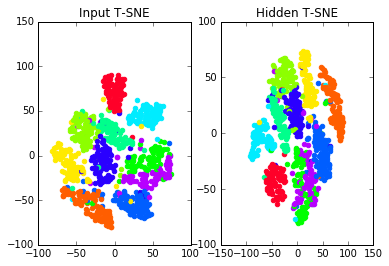

In [14]:
from sklearn.manifold import TSNE
tsne_input = TSNE(n_components=2).fit_transform(mnist.test.images)
tsne_hidden = TSNE(n_components=2).fit_transform(hidden_activation_test)

NUM_COLORS = 10
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.set_title('Input T-SNE')
ax2.set_title('Hidden T-SNE')

for i in range(1000):
    lbl = np.argmax(mnist.test.labels[i,:])
    ax1.scatter(tsne_input[i,0], tsne_input[i,1], color=colors[lbl])
    ax2.scatter(tsne_hidden[i,0], tsne_hidden[i,1], color=colors[lbl])
plt.show()